### Compute the score for each edge based on the embedding of the two nodes
Only consider connected graph\
The score is computed using the distance of the two vectors, and would be large if the embeddings are different.

In [95]:
import torch
import torch.nn.functional as F
from torch_scatter import scatter_add
from torch_sparse import coalesce

from torch.nn import PairwiseDistance
from torch import sigmoid as sigmoid
from torch import tanh as tanh
from torch import softmax as softmax
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
import torch_geometric.utils as U
 
import networkx as nx
import numpy as np


In [518]:
# distance (based on the node embedding) + GNN
## function to compute the score for each edge
# normalize: tanh, softmax, sigmoid, standard
def compute_distance_score(p_norm=0.5, normalize = True, edge_index=[], x=[], self_add=0.5):
    
    pdist = PairwiseDistance(p_norm)
    dist = pdist(x[edge_index[0]], x[edge_index[1]])
    
    if normalize == True:
        dist_norm = (dist - torch.min(dist)) / (torch.max(dist) - torch.min(dist))
    else:
        print('Wrong type of normalize, use softmax as default')
        dist_norm = dist
    return dist_norm + self_add

In [520]:
def node__cluster_search(edge_score, edge_index, i, upper_bound, greedy=False):
# stop after reaching upper_bound for the first time
    selected_score = []
    in_cluster = [i]
    selected_edge = torch.tensor([])
    while (sum(selected_score) < upper_bound):
        potential_edge_index = torch.tensor([])
        potential_score = torch.tensor([])
        for i in in_cluster:
            # the first element in edge is in cluster
            potential_edge_index = torch.cat([potential_edge_index, edge_index[:,edge_index[0]==i]], dim=-1) 
            potential_score = torch.cat([potential_score, edge_score[edge_index[0]==i]], dim=-1)
            for j in in_cluster:
                potential_score = potential_score[potential_edge_index[1]!=j]
                potential_edge_index = potential_edge_index[:,potential_edge_index[1]!=j]
        if (potential_score.shape[0]==0):
            print('The current cluster has contained all nodes in the graph')
            break
        added_score = torch.min(potential_score)
        added_edge = potential_edge_index[:,torch.where(potential_score==added_score)]
        selected_edge = torch.cat([selected_edge, added_edge], dim=-1)   
        selected_score += [added_score.item()]
        in_cluster += [int(added_edge[1].item())]
    if (greedy==False):
        in_cluster = in_cluster[0:(len(in_cluster)-1)]
        selected_edge = selected_edge[:,0:(selected_edge.shape[1]-1)]
        selected_score = selected_score[0:(len(selected_score)-1)]


    return in_cluster, selected_edge, selected_score

In [593]:
# Cluster selection
# method: 
# sample: False: construct cluster for each node, 
#         true: construct cluster for sampled nodes, until cover all nodes (regardless of select)
# select: True: use heuristic strategy to select clusters
#          
def cluster_assignment(edge_score, edge_index, upper_bound, greedy=False, sample=False, select=True):
    num_nodes = torch.max(edge_index) + 1
    assignment_matrix = torch.tensor([])
    node_score_matrix = torch.tensor([])
    cluster_score = torch.tensor([])
    # cluster assignment matrix (C*N C: number of considered clusters, N: number of nodes)
    # 

    num_cluster = num_nodes 
    assignment_matrix = torch.zeros((num_cluster, num_nodes))
    node_score_matrix = torch.zeros([num_cluster, num_nodes])
    cluster_score = torch.zeros([num_cluster])

    for i in range(num_cluster):
        in_cluster, selected_edge, selected_score = node__cluster_search(edge_score, edge_index, i, upper_bound, greedy)
        assignment_matrix[i,in_cluster] = 1
        cluster_score[i] = sum(selected_score)
        for j in range(len(selected_score)):
            node_score_matrix[i,int(selected_edge[0,j].item())] += selected_score[j]/2
            node_score_matrix[i,int(selected_edge[1,j].item())] += selected_score[j]/2
    # delete repeated cluster
    _, index, _ = np.unique(assignment_matrix.numpy(), return_index=True, return_inverse=True, axis=0)
    assignment_matrix = assignment_matrix[index,]
    node_score_matrix = node_score_matrix[index,]
    cluster_score = cluster_score[index]
    
    if select == True:
        selected_assignment_matrix = torch.tensor([])
        selected_node_score_matrix = torch.tensor([])
        potential_assignment_matrix = assignment_matrix
        potential_node_score_matrix = node_score_matrix
        potential_cluster_score = cluster_score
        potential_node_index = torch.ones(num_nodes) # node index that hasn't been selected
        while (torch.sum(torch.sum(selected_assignment_matrix, dim=0)>0) < num_nodes):
            num_of_element = torch.sum(potential_assignment_matrix[:,potential_node_index>0], dim=1)
            max_cluster_score = torch.max(potential_cluster_score[torch.where(num_of_element==torch.max(num_of_element))])
            selected_cluster_index = torch.where(potential_cluster_score==max_cluster_score)[0]
            added_assignment_matrix = potential_assignment_matrix[selected_cluster_index,:]
            added_node_score_matrix = potential_node_score_matrix[selected_cluster_index,:]
            selected_assignment_matrix = torch.cat([selected_assignment_matrix, added_assignment_matrix], dim=0)
            potential_assignment_matrix = torch.cat([potential_assignment_matrix[0:selected_cluster_index,:],potential_assignment_matrix[selected_cluster_index+1:,:]],dim=0)
            selected_node_score_matrix = torch.cat([selected_node_score_matrix, added_node_score_matrix], dim=0)
            potential_node_score_matrix = torch.cat([potential_node_score_matrix[0:selected_cluster_index,:],potential_node_score_matrix[selected_cluster_index+1:,:]],dim=0)
            potential_node_index[torch.sum(selected_assignment_matrix, dim=0)>0] = 0
    elif select==False:
        selected_assignment_matrix = assignment_matrix
        selected_node_score_matrix = node_score_matrix
    return selected_assignment_matrix, selected_node_score_matrix 
        
# return: new_edge_index, new_x

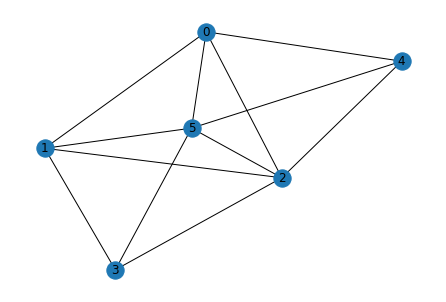

In [621]:
G = nx.connected_watts_strogatz_graph(n=6, k=4, p=0.4)
nx.draw(G, with_labels=True)
G0 = U.from_networkx(G)
edge_index = G0.edge_index
G0.x = torch.randn(6,3) # feature_size = 3
x = G0.x

In [622]:
edge_score = compute_distance_score(p_norm=2, normalize = True, edge_index = edge_index, x=x)
print(edge_score)
print(edge_index)

tensor([0.5000, 1.3700, 0.8237, 0.6397, 0.5000, 1.1660, 0.5262, 1.1383, 0.8237,
        1.1660, 0.9098, 1.5000, 1.0469, 0.5262, 1.0469, 1.2714, 0.6397, 0.9098,
        0.8934, 1.3700, 1.1383, 1.5000, 1.2714, 0.8934])
tensor([[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 5, 5],
        [1, 5, 2, 4, 0, 2, 3, 5, 0, 1, 4, 5, 3, 1, 2, 5, 0, 2, 5, 0, 1, 2, 3, 4]])


In [623]:
selected_assignment_matrix, selected_node_score_matrix = cluster_assignment(edge_score, edge_index, upper_bound=2, greedy=False, select=True)
selected_assignment_matrix.shape


torch.Size([2, 6])

In [624]:
adj = U.to_dense_adj(edge_index)[0]
adj_new = torch.matmul(torch.matmul(selected_assignment_matrix,adj),selected_assignment_matrix.t()) # connectivity relationship
adj_new[adj_new>0] = 1
adj_new = U.remove_self_loops(U.dense_to_sparse(adj_new)[0])[0]
adj_new

tensor([[0, 1],
        [1, 0]])

In [625]:
x_new = torch.matmul(selected_node_score_matrix, x)
x_new

tensor([[ 0.9470, -0.4556,  4.1614],
        [ 0.6166,  1.6959,  2.3808]])